In [1]:
import sys
sys.path.append("..")
import feature_engineer as fe
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score
import tensorflow_decision_forests as tfdf

2023-07-29 20:22:55.166937: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-29 20:22:55.194531: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-29 20:22:55.195152: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 20:22:55.810932: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify down

In [2]:
with open('../data/dataset_df.pkl', 'rb') as file:
    dataset_df = pickle.load(file)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (26296946, 20)


In [3]:
with open('../data/labels.pkl', 'rb') as file:
    labels = pickle.load(file)
print("Full train label shape is {}".format(labels.shape))

Full train label shape is (424116, 4)


In [4]:
dataset_df = fe.feature_engineer1(dataset_df)
print("Full prepared dataset shape is {}".format(dataset_df.shape))

Full prepared dataset shape is (70686, 23)


In [5]:
FEATURES = [c for c in dataset_df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = dataset_df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 22 features
We will train with 23562 users info


In [6]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

for i, (train_index, test_index) in enumerate(gkf.split(X=dataset_df, groups=dataset_df.index)):
    print('### Fold',i+1)
    
    for t in range(1,19):
        print(t,', ',end='')
        
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        train_x = dataset_df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = labels.loc[labels.q==t].set_index('session').loc[train_users]
        
        valid_x = dataset_df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = labels.loc[labels.q==t].set_index('session').loc[valid_users]

        train_x["correct"] = train_y["correct"]
        valid_x["correct"] = valid_y["correct"]

        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_x.loc[:, train_x.columns != 'level_group'], label="correct")
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_x.loc[:, valid_x.columns != 'level_group'], label="correct")
        
        clf = tfdf.keras.GradientBoostedTreesModel(verbose=0) 
        clf.compile(metrics=["accuracy"])
        clf.fit(x=train_ds)
        models[f'{grp}_{t}'] = clf 

        oof.loc[valid_users, t-1] = clf.predict(x=valid_ds).flatten()

### Fold 1
1 , 

2023-07-29 20:23:22.959039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-29 20:23:22.959315: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
[WARNING 23-07-29 20:23:23.0272 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:23.0272 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:23.0272 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set bu

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5/5 [==============================] - 0s 7ms/step
2 , 

[WARNING 23-07-29 20:23:29.3140 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:29.3140 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:29.3140 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:23:30.8553 AEST kernel.cc:1243] Loading model from path /tmp/tmpgyj8arf6/model/ with prefix 705138644d2840e5
[INFO 23-07-29 20:23:30.8563 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
3 , 

[WARNING 23-07-29 20:23:31.1396 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:31.1396 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:31.1396 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:23:32.7574 AEST kernel.cc:1243] Loading model from path /tmp/tmpgly8xrhd/model/ with prefix eda9932f4a8a4e7d
[INFO 23-07-29 20:23:32.7588 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
4 , 

[WARNING 23-07-29 20:23:33.0321 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:33.0322 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:33.0322 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:23:35.2792 AEST kernel.cc:1243] Loading model from path /tmp/tmp5s8eqhhy/model/ with prefix a1704f93adc445c9
[INFO 23-07-29 20:23:35.2826 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
5 , 

[WARNING 23-07-29 20:23:35.5800 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:35.5800 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:35.5800 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:23:36.9986 AEST kernel.cc:1243] Loading model from path /tmp/tmphalj69_u/model/ with prefix 6c51d737dd814016
[INFO 23-07-29 20:23:37.0000 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
6 , 

[WARNING 23-07-29 20:23:37.2795 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:37.2795 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:37.2795 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


[INFO 23-07-29 20:23:38.7091 AEST kernel.cc:1243] Loading model from path /tmp/tmpe5183wlq/model/ with prefix c0ffece3a3a54ff6
[INFO 23-07-29 20:23:38.7104 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:23:38.7105 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
7 , 

[WARNING 23-07-29 20:23:39.0015 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:39.0015 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:39.0015 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:23:40.4314 AEST kernel.cc:1243] Loading model from path /tmp/tmpd2qc9myn/model/ with prefix 9b62cb4c2e0647c4
[INFO 23-07-29 20:23:40.4331 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
8 , 

[WARNING 23-07-29 20:23:40.7111 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:40.7111 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:40.7111 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:23:41.8474 AEST kernel.cc:1243] Loading model from path /tmp/tmpp73oh815/model/ with prefix 2ed6f3ca455b4507
[INFO 23-07-29 20:23:41.8482 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
9 , 

[WARNING 23-07-29 20:23:42.1089 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:42.1089 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:42.1089 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:23:43.4509 AEST kernel.cc:1243] Loading model from path /tmp/tmpw15aud7x/model/ with prefix 8e7c8a06f2284824
[INFO 23-07-29 20:23:43.4521 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
10 , 

[WARNING 23-07-29 20:23:43.7313 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:43.7313 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:43.7313 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:23:45.0612 AEST kernel.cc:1243] Loading model from path /tmp/tmpncwevbvi/model/ with prefix 22b8ba343a634f7d
[INFO 23-07-29 20:23:45.0625 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
11 , 

[WARNING 23-07-29 20:23:45.3425 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:45.3425 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:45.3425 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:23:46.6303 AEST kernel.cc:1243] Loading model from path /tmp/tmpfui9wmco/model/ with prefix d37e9393ec7d4a40
[INFO 23-07-29 20:23:46.6318 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
12 , 

[WARNING 23-07-29 20:23:46.9259 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:46.9259 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:46.9259 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:23:48.5027 AEST kernel.cc:1243] Loading model from path /tmp/tmpa_hcbchg/model/ with prefix cbb7df0f95664283
[INFO 23-07-29 20:23:48.5040 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
13 , 

[WARNING 23-07-29 20:23:48.7922 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:48.7922 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:48.7922 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:23:50.4488 AEST kernel.cc:1243] Loading model from path /tmp/tmpa0ia8agw/model/ with prefix a7d2e05723964bde
[INFO 23-07-29 20:23:50.4505 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:23:50.4505 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
14 , 

[WARNING 23-07-29 20:23:50.7268 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:50.7269 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:50.7269 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:23:52.4312 AEST kernel.cc:1243] Loading model from path /tmp/tmp4l0i8k6m/model/ with prefix 61e05ea607144c34
[INFO 23-07-29 20:23:52.4331 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 8ms/step
15 , 

[WARNING 23-07-29 20:23:52.7299 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:52.7299 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:52.7300 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:23:55.5051 AEST kernel.cc:1243] Loading model from path /tmp/tmphduvqfaf/model/ with prefix dc4b750325fd40ae
[INFO 23-07-29 20:23:55.5096 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 8ms/step
16 , 

[WARNING 23-07-29 20:23:55.8103 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:55.8103 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:55.8104 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:23:56.8934 AEST kernel.cc:1243] Loading model from path /tmp/tmpkhkbitqc/model/ with prefix c55cd0b0b2134e9d
[INFO 23-07-29 20:23:56.8941 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
17 , 

[WARNING 23-07-29 20:23:57.1687 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:57.1687 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:57.1687 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:23:58.3822 AEST kernel.cc:1243] Loading model from path /tmp/tmpay6e9l6e/model/ with prefix b4157a41b4db4499
[INFO 23-07-29 20:23:58.3832 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
18 , 

[WARNING 23-07-29 20:23:58.6623 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:58.6623 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:23:58.6623 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:00.0986 AEST kernel.cc:1243] Loading model from path /tmp/tmp6gddx1g2/model/ with prefix 9a83a0d518e34b92
[INFO 23-07-29 20:24:00.0999 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
### Fold 2
1 , 

[WARNING 23-07-29 20:24:00.3863 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:00.3863 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:00.3863 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:24:02.4493 AEST kernel.cc:1243] Loading model from path /tmp/tmpj2wex5gk/model/ with prefix a5742a3c3e4b4779
[INFO 23-07-29 20:24:02.4522 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:24:02.4522 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
2 , 

[WARNING 23-07-29 20:24:02.8057 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:02.8057 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:02.8057 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:24:03.8689 AEST kernel.cc:1243] Loading model from path /tmp/tmphhke_bnn/model/ with prefix 6037e85ecbf24330
[INFO 23-07-29 20:24:03.8694 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
3 , 

[WARNING 23-07-29 20:24:04.1626 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:04.1626 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:04.1626 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:05.3288 AEST kernel.cc:1243] Loading model from path /tmp/tmptit9na43/model/ with prefix da479aad00764d15
[INFO 23-07-29 20:24:05.3296 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
4 , 

[WARNING 23-07-29 20:24:05.5933 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:05.5933 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:05.5933 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:07.1408 AEST kernel.cc:1243] Loading model from path /tmp/tmpedxmhhv_/model/ with prefix 67181c6621df4c5c
[INFO 23-07-29 20:24:07.1425 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
5 , 

[WARNING 23-07-29 20:24:07.4111 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:07.4111 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:07.4111 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:08.8337 AEST kernel.cc:1243] Loading model from path /tmp/tmpuxfmf8ny/model/ with prefix 0369df6227604743
[INFO 23-07-29 20:24:08.8351 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
6 , 

[WARNING 23-07-29 20:24:09.0966 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:09.0966 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:09.0966 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:10.8396 AEST kernel.cc:1243] Loading model from path /tmp/tmpcxyw8hnw/model/ with prefix ddd65893478b424b
[INFO 23-07-29 20:24:10.8416 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
7 , 

[WARNING 23-07-29 20:24:11.1155 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:11.1155 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:11.1155 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:24:12.4330 AEST kernel.cc:1243] Loading model from path /tmp/tmppikrhipf/model/ with prefix db09922f31e94067
[INFO 23-07-29 20:24:12.4343 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
8 , 

[WARNING 23-07-29 20:24:12.7304 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:12.7304 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:12.7304 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:13.9448 AEST kernel.cc:1243] Loading model from path /tmp/tmpmy1sr_62/model/ with prefix 069e54f3f4ea44f0
[INFO 23-07-29 20:24:13.9457 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:24:13.9457 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
9 , 

[WARNING 23-07-29 20:24:14.2167 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:14.2167 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:14.2167 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:24:15.6539 AEST kernel.cc:1243] Loading model from path /tmp/tmpcz_jftdn/model/ with prefix c6e3b8bd943944c5
[INFO 23-07-29 20:24:15.6555 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
10 , 

[WARNING 23-07-29 20:24:16.1668 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:16.1668 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:16.1668 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:17.3556 AEST kernel.cc:1243] Loading model from path /tmp/tmplz1hk11r/model/ with prefix 72433e15e297485f
[INFO 23-07-29 20:24:17.3566 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
11 , 

[WARNING 23-07-29 20:24:17.6422 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:17.6422 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:17.6423 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:18.9383 AEST kernel.cc:1243] Loading model from path /tmp/tmpxhbo3jf3/model/ with prefix 6b773025416b4498
[INFO 23-07-29 20:24:18.9398 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
12 , 

[WARNING 23-07-29 20:24:19.2003 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:19.2003 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:19.2004 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:20.2475 AEST kernel.cc:1243] Loading model from path /tmp/tmpxuvr5x1s/model/ with prefix a5b298911794463c
[INFO 23-07-29 20:24:20.2483 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
13 , 

[WARNING 23-07-29 20:24:20.5078 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:20.5079 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:20.5079 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:21.9420 AEST kernel.cc:1243] Loading model from path /tmp/tmpsdbl__42/model/ with prefix 0239a6939cfb452b
[INFO 23-07-29 20:24:21.9433 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
14 , 

[WARNING 23-07-29 20:24:22.2019 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:22.2019 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:22.2019 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:24.1022 AEST kernel.cc:1243] Loading model from path /tmp/tmpmmwjl_r7/model/ with prefix 077fe8ce738f43d1
[INFO 23-07-29 20:24:24.1048 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:24:24.1048 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 9ms/step
15 , 

[WARNING 23-07-29 20:24:24.3884 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:24.3884 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:24.3884 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:25.7674 AEST kernel.cc:1243] Loading model from path /tmp/tmpy57jc77p/model/ with prefix cfa5042d5d804bb7
[INFO 23-07-29 20:24:25.7687 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
16 , 

[WARNING 23-07-29 20:24:26.0225 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:26.0225 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:26.0225 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:27.2689 AEST kernel.cc:1243] Loading model from path /tmp/tmp9uiu_vzr/model/ with prefix 42c987f09bbb4d9e
[INFO 23-07-29 20:24:27.2699 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
17 , 

[WARNING 23-07-29 20:24:27.5374 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:27.5374 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:27.5374 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:28.6127 AEST kernel.cc:1243] Loading model from path /tmp/tmpw1ahk9vf/model/ with prefix f4c1f42175c9457e
[INFO 23-07-29 20:24:28.6133 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
18 , 

[WARNING 23-07-29 20:24:28.9115 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:28.9115 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:28.9115 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:24:30.2673 AEST kernel.cc:1243] Loading model from path /tmp/tmpn7otyf70/model/ with prefix 4bb0dfa88b8c481d
[INFO 23-07-29 20:24:30.2683 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
### Fold 3
1 , 

[WARNING 23-07-29 20:24:30.5542 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:30.5543 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:30.5543 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:24:32.4352 AEST kernel.cc:1243] Loading model from path /tmp/tmp86el8acz/model/ with prefix 3ecd2d94ab7544fb
[INFO 23-07-29 20:24:32.4378 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
2 , 

[WARNING 23-07-29 20:24:32.7232 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:32.7232 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:32.7232 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:24:34.0328 AEST kernel.cc:1243] Loading model from path /tmp/tmp97uzcx1p/model/ with prefix 4a5b1a25c6eb4ec9
[INFO 23-07-29 20:24:34.0338 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
3 , 

[WARNING 23-07-29 20:24:34.3325 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:34.3325 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:34.3326 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:35.3797 AEST kernel.cc:1243] Loading model from path /tmp/tmp9tzrsev3/model/ with prefix 42789d778ee14dcb
[INFO 23-07-29 20:24:35.3805 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:24:35.3805 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
4 , 

[WARNING 23-07-29 20:24:35.6532 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:35.6533 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:35.6533 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:24:37.6611 AEST kernel.cc:1243] Loading model from path /tmp/tmpw__3363s/model/ with prefix 6826ffba3fa046d5
[INFO 23-07-29 20:24:37.6637 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 14ms/step
5 , 

[WARNING 23-07-29 20:24:38.1580 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:38.1580 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:38.1580 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:24:39.6363 AEST kernel.cc:1243] Loading model from path /tmp/tmph90iwej_/model/ with prefix f18285d3dc86400d
[INFO 23-07-29 20:24:39.6374 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
6 , 

[WARNING 23-07-29 20:24:39.9648 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:39.9649 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:39.9649 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:41.4558 AEST kernel.cc:1243] Loading model from path /tmp/tmpn9mkt4w4/model/ with prefix 8ca8dcd4767b43d9
[INFO 23-07-29 20:24:41.4578 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
7 , 

[WARNING 23-07-29 20:24:41.7456 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:41.7456 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:41.7456 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:43.1558 AEST kernel.cc:1243] Loading model from path /tmp/tmpr_12_xth/model/ with prefix aa932fea8b5d4a99
[INFO 23-07-29 20:24:43.1572 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 9ms/step
8 , 

[WARNING 23-07-29 20:24:43.4594 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:43.4594 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:43.4594 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:44.7346 AEST kernel.cc:1243] Loading model from path /tmp/tmp99ia2fi5/model/ with prefix 653dae0d01284a74
[INFO 23-07-29 20:24:44.7358 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
9 , 

[WARNING 23-07-29 20:24:44.9990 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:44.9990 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:44.9990 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:46.4353 AEST kernel.cc:1243] Loading model from path /tmp/tmp48z47wku/model/ with prefix 0a2095d9d3d14214
[INFO 23-07-29 20:24:46.4369 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:24:46.4369 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
10 , 

[WARNING 23-07-29 20:24:46.7033 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:46.7034 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:46.7034 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:24:48.4278 AEST kernel.cc:1243] Loading model from path /tmp/tmp8w9e2zug/model/ with prefix e180cf3177954c1e
[INFO 23-07-29 20:24:48.4295 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
11 , 

[WARNING 23-07-29 20:24:48.7072 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:48.7073 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:48.7073 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:24:49.9988 AEST kernel.cc:1243] Loading model from path /tmp/tmpphbfs7x3/model/ with prefix 63237d4642954025
[INFO 23-07-29 20:24:50.0005 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 10ms/step
12 , 

[WARNING 23-07-29 20:24:50.3619 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:50.3619 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:50.3619 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:24:51.8702 AEST kernel.cc:1243] Loading model from path /tmp/tmpllpyc03b/model/ with prefix 4903a99061aa4b26
[INFO 23-07-29 20:24:51.8715 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
13 , 

[WARNING 23-07-29 20:24:52.1525 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:52.1526 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:52.1526 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:24:53.6605 AEST kernel.cc:1243] Loading model from path /tmp/tmpskwazok8/model/ with prefix c8f8f565c0a84b9d
[INFO 23-07-29 20:24:53.6618 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 9ms/step
14 , 

[WARNING 23-07-29 20:24:54.0477 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:54.0477 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:54.0477 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:24:57.3272 AEST kernel.cc:1243] Loading model from path /tmp/tmpxq62ym8f/model/ with prefix b3a040c0c2e8437d
[INFO 23-07-29 20:24:57.3322 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:24:57.3322 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
15 , 

[WARNING 23-07-29 20:24:57.6573 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:57.6573 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:57.6573 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:24:59.2562 AEST kernel.cc:1243] Loading model from path /tmp/tmppjn7id_e/model/ with prefix 8d290c451eb54d31
[INFO 23-07-29 20:24:59.2579 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
16 , 

[WARNING 23-07-29 20:24:59.5555 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:59.5555 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:24:59.5555 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:25:01.1100 AEST kernel.cc:1243] Loading model from path /tmp/tmpx28zg0yr/model/ with prefix cef0425f52844a50
[INFO 23-07-29 20:25:01.1112 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
17 , 

[WARNING 23-07-29 20:25:01.4177 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:01.4178 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:01.4178 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:25:02.7432 AEST kernel.cc:1243] Loading model from path /tmp/tmpczqv60eg/model/ with prefix 7eb336e61637403e
[INFO 23-07-29 20:25:02.7452 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 8ms/step
18 , 

[WARNING 23-07-29 20:25:03.1148 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:03.1148 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:03.1148 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:04.8390 AEST kernel.cc:1243] Loading model from path /tmp/tmprvp4fw9j/model/ with prefix 6b79b57d6b134ca3
[INFO 23-07-29 20:25:04.8406 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 9ms/step
### Fold 4
1 , 

[WARNING 23-07-29 20:25:05.1529 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:05.1529 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:05.1529 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:06.7100 AEST kernel.cc:1243] Loading model from path /tmp/tmpzkflsk6k/model/ with prefix 9cca910fa9704d25
[INFO 23-07-29 20:25:06.7120 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
2 , 

[WARNING 23-07-29 20:25:06.9889 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:06.9889 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:06.9889 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:25:08.5245 AEST kernel.cc:1243] Loading model from path /tmp/tmpb9perhss/model/ with prefix a07cccffba104030
[INFO 23-07-29 20:25:08.5256 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:25:08.5256 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
3 , 

[WARNING 23-07-29 20:25:08.8392 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:08.8393 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:08.8393 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:25:10.4709 AEST kernel.cc:1243] Loading model from path /tmp/tmpsgccq2ol/model/ with prefix 8d4fc1bdec834d01
[INFO 23-07-29 20:25:10.4727 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
4 , 

[WARNING 23-07-29 20:25:10.7878 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:10.7879 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:10.7879 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:12.4932 AEST kernel.cc:1243] Loading model from path /tmp/tmpgl221wl3/model/ with prefix c44f1dfd612d405f
[INFO 23-07-29 20:25:12.4949 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
5 , 

[WARNING 23-07-29 20:25:12.7692 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:12.7692 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:12.7692 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:14.2784 AEST kernel.cc:1243] Loading model from path /tmp/tmpbaf5a7id/model/ with prefix b8b99e93535546b3
[INFO 23-07-29 20:25:14.2802 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 8ms/step
6 , 

[WARNING 23-07-29 20:25:14.5678 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:14.5678 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:14.5678 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:15.9958 AEST kernel.cc:1243] Loading model from path /tmp/tmpmgwyx53d/model/ with prefix d8cbd9216737477b
[INFO 23-07-29 20:25:15.9974 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
7 , 

[WARNING 23-07-29 20:25:16.2747 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:16.2747 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:16.2747 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:17.9072 AEST kernel.cc:1243] Loading model from path /tmp/tmprfub20ac/model/ with prefix 8903b942d0434db4
[INFO 23-07-29 20:25:17.9089 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 5ms/step
8 , 

[WARNING 23-07-29 20:25:18.1774 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:18.1774 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:18.1774 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:25:19.5463 AEST kernel.cc:1243] Loading model from path /tmp/tmpktkkl52c/model/ with prefix 80b2dcd2c9074734
[INFO 23-07-29 20:25:19.5476 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:25:19.5477 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 9ms/step
9 , 

[WARNING 23-07-29 20:25:19.8912 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:19.8912 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:19.8912 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:25:21.2604 AEST kernel.cc:1243] Loading model from path /tmp/tmpuj3xhcd0/model/ with prefix 60d4b3fe19fa4693
[INFO 23-07-29 20:25:21.2617 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
10 , 

[WARNING 23-07-29 20:25:21.5506 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:21.5506 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:21.5506 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:23.0927 AEST kernel.cc:1243] Loading model from path /tmp/tmp2yv8ajec/model/ with prefix 2c0ca1ba4c66411c
[INFO 23-07-29 20:25:23.0946 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
11 , 

[WARNING 23-07-29 20:25:23.3613 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:23.3613 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:23.3614 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:24.8674 AEST kernel.cc:1243] Loading model from path /tmp/tmpuisjjcqp/model/ with prefix 2edf7793626843e7
[INFO 23-07-29 20:25:24.8689 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 8ms/step
12 , 

[WARNING 23-07-29 20:25:25.1499 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:25.1499 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:25.1499 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:26.5047 AEST kernel.cc:1243] Loading model from path /tmp/tmpl_14s3_a/model/ with prefix 9980ece3cec543c1
[INFO 23-07-29 20:25:26.5058 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
13 , 

[WARNING 23-07-29 20:25:27.1325 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:27.1325 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:27.1325 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:28.4718 AEST kernel.cc:1243] Loading model from path /tmp/tmp8rsh8pbw/model/ with prefix 15296a521efc4ef0
[INFO 23-07-29 20:25:28.4733 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
14 , 

[WARNING 23-07-29 20:25:28.7514 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:28.7515 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:28.7515 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:30.8825 AEST kernel.cc:1243] Loading model from path /tmp/tmp_9oa4otc/model/ with prefix 6bcfd7bcfec44d4c
[INFO 23-07-29 20:25:30.8855 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:25:30.8856 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 8ms/step
15 , 

[WARNING 23-07-29 20:25:31.1598 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:31.1598 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:31.1598 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:25:33.3244 AEST kernel.cc:1243] Loading model from path /tmp/tmpvn43fksm/model/ with prefix 0c6869d9ba4d4b61
[INFO 23-07-29 20:25:33.3284 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 9ms/step
16 , 

[WARNING 23-07-29 20:25:33.7069 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:33.7069 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:33.7069 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:35.6175 AEST kernel.cc:1243] Loading model from path /tmp/tmpw5sim6p2/model/ with prefix b9dc95daeb0f4ebb
[INFO 23-07-29 20:25:35.6193 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
17 , 

[WARNING 23-07-29 20:25:35.8992 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:35.8992 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:35.8992 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:37.7478 AEST kernel.cc:1243] Loading model from path /tmp/tmp1612981r/model/ with prefix bd6e1b7206814c82
[INFO 23-07-29 20:25:37.7498 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
18 , 

[WARNING 23-07-29 20:25:38.0230 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:38.0230 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:38.0230 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:25:39.4627 AEST kernel.cc:1243] Loading model from path /tmp/tmp64d7ga3x/model/ with prefix bbb109b834f74a88
[INFO 23-07-29 20:25:39.4642 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
### Fold 5
1 , 

[WARNING 23-07-29 20:25:39.7687 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:39.7687 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:39.7687 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:42.0441 AEST kernel.cc:1243] Loading model from path /tmp/tmp354o8drn/model/ with prefix 37168c882de24a3c
[INFO 23-07-29 20:25:42.0477 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:25:42.0477 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
2 , 

[WARNING 23-07-29 20:25:42.3114 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:42.3114 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:42.3114 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:44.4212 AEST kernel.cc:1243] Loading model from path /tmp/tmptt523det/model/ with prefix 7a1e47f748a3416d
[INFO 23-07-29 20:25:44.4233 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
3 , 

[WARNING 23-07-29 20:25:44.6842 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:44.6842 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:44.6842 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


5/5 [==============================] - 0s 6ms/step


[INFO 23-07-29 20:25:45.7428 AEST kernel.cc:1243] Loading model from path /tmp/tmp83k5w7k3/model/ with prefix c8a820b5be274708
[INFO 23-07-29 20:25:45.7434 AEST kernel.cc:1075] Use fast generic engine


4 , 

[WARNING 23-07-29 20:25:45.9923 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:45.9923 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:45.9923 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:47.8448 AEST kernel.cc:1243] Loading model from path /tmp/tmpfi9xpz5_/model/ with prefix 23008c468ee4432a
[INFO 23-07-29 20:25:47.8472 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
5 , 

[WARNING 23-07-29 20:25:48.1265 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:48.1266 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:48.1266 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:49.4778 AEST kernel.cc:1243] Loading model from path /tmp/tmp4vy792sr/model/ with prefix da4a4261cb6545d5
[INFO 23-07-29 20:25:49.4793 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
6 , 

[WARNING 23-07-29 20:25:49.7460 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:49.7461 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:49.7461 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:51.3198 AEST kernel.cc:1243] Loading model from path /tmp/tmpz16k7i6u/model/ with prefix d7eacd45eec044c8
[INFO 23-07-29 20:25:51.3219 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
7 , 

[WARNING 23-07-29 20:25:51.5850 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:51.5850 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:51.5850 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:52.9245 AEST kernel.cc:1243] Loading model from path /tmp/tmprd96x1pp/model/ with prefix 06ef31ec5773405c
[INFO 23-07-29 20:25:52.9257 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:25:52.9257 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
8 , 

[WARNING 23-07-29 20:25:53.1971 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:53.1971 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:53.1971 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:54.3364 AEST kernel.cc:1243] Loading model from path /tmp/tmpx9xjitx5/model/ with prefix 752d35af272c4efb
[INFO 23-07-29 20:25:54.3372 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
9 , 

[WARNING 23-07-29 20:25:54.5950 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:54.5950 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:54.5950 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:56.1481 AEST kernel.cc:1243] Loading model from path /tmp/tmp1i7otwpv/model/ with prefix 901c5a7b2f6a42ac
[INFO 23-07-29 20:25:56.1500 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
10 , 

[WARNING 23-07-29 20:25:56.4178 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:56.4178 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:56.4178 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:57.7921 AEST kernel.cc:1243] Loading model from path /tmp/tmpt75znjee/model/ with prefix 23b1b99d8d904379
[INFO 23-07-29 20:25:57.7935 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
11 , 

[WARNING 23-07-29 20:25:58.0632 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:58.0632 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:25:58.0632 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:25:59.7482 AEST kernel.cc:1243] Loading model from path /tmp/tmpq6pqefv8/model/ with prefix b579a570876b45b6
[INFO 23-07-29 20:25:59.7503 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
12 , 

[WARNING 23-07-29 20:26:00.0076 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:26:00.0076 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:26:00.0076 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:26:01.1897 AEST kernel.cc:1243] Loading model from path /tmp/tmpow78vygy/model/ with prefix afc96a94c7154a85
[INFO 23-07-29 20:26:01.1906 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
13 , 

[WARNING 23-07-29 20:26:01.4704 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:26:01.4704 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:26:01.4704 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:26:03.0888 AEST kernel.cc:1243] Loading model from path /tmp/tmpfbqe9pvj/model/ with prefix 9c8bab22878a408d
[INFO 23-07-29 20:26:03.0911 AEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:26:03.0911 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
14 , 

[WARNING 23-07-29 20:26:03.3595 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:26:03.3595 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:26:03.3595 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:26:04.8561 AEST kernel.cc:1243] Loading model from path /tmp/tmp593ziu3x/model/ with prefix f6d37381cce641b6
[INFO 23-07-29 20:26:04.8582 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
15 , 

[WARNING 23-07-29 20:26:05.1313 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:26:05.1313 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:26:05.1313 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/5 [=====>........................] - ETA: 0s

[INFO 23-07-29 20:26:06.7893 AEST kernel.cc:1243] Loading model from path /tmp/tmphdg_8h_o/model/ with prefix bf0040f745b24d9e
[INFO 23-07-29 20:26:06.7913 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 6ms/step
16 , 

[WARNING 23-07-29 20:26:07.0498 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:26:07.0498 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:26:07.0498 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


5/5 [==============================] - 0s 6ms/step


[INFO 23-07-29 20:26:08.1159 AEST kernel.cc:1243] Loading model from path /tmp/tmp_cjr9ui7/model/ with prefix 9071a5101d8b47b9
[INFO 23-07-29 20:26:08.1165 AEST kernel.cc:1075] Use fast generic engine


17 , 

[WARNING 23-07-29 20:26:08.3739 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:26:08.3739 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:26:08.3739 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:26:09.6942 AEST kernel.cc:1243] Loading model from path /tmp/tmp3raxev_e/model/ with prefix ae2a56e52d2940c4
[INFO 23-07-29 20:26:09.6954 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 7ms/step
18 , 

[WARNING 23-07-29 20:26:10.3816 AEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:26:10.3816 AEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:26:10.3816 AEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-07-29 20:26:11.7022 AEST kernel.cc:1243] Loading model from path /tmp/tmp9kcwi5zs/model/ with prefix 9644e456a7124856
[INFO 23-07-29 20:26:11.7035 AEST kernel.cc:1075] Use fast generic engine


5/5 [==============================] - 0s 8ms/step


In [7]:
with open("../data/GBT_FE1_models.pkl", "wb") as f:
    pickle.dump(models, f)
oof.to_csv("../data/GBT_FE1_predictions.csv", index=True)

In [8]:
true = oof.copy()
for k in range(18):
    tmp = labels.loc[labels.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [9]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

print("Best threshold ", best_threshold, "\tF1 score ", best_score)

Best threshold  0.6300000000000002 	F1 score  0.6697642404076668


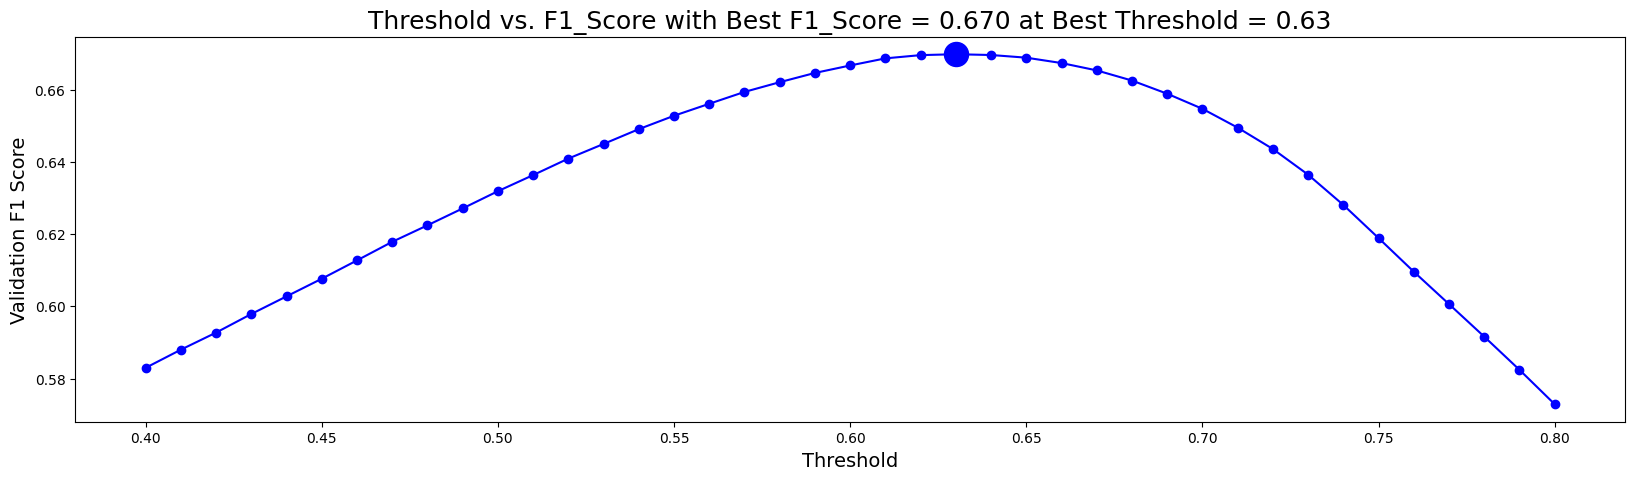

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [11]:
print('When using optimal threshold...')
for k in range(18):
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)

m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.5564597905453098
Q1: F1 = 0.5021225510592486
Q2: F1 = 0.4876750778776089
Q3: F1 = 0.5906480457343853
Q4: F1 = 0.5489874111577213
Q5: F1 = 0.5898408745951681
Q6: F1 = 0.5680655015609919
Q7: F1 = 0.5240967801528946
Q8: F1 = 0.5822058663160693
Q9: F1 = 0.4582246082377257
Q10: F1 = 0.577254204186698
Q11: F1 = 0.4801915158304275
Q12: F1 = 0.4274706294117307
Q13: F1 = 0.5909885094576702
Q14: F1 = 0.47045587605210715
Q15: F1 = 0.451227096248228
Q16: F1 = 0.5148009778146764
Q17: F1 = 0.4918362654623519
==> Overall F1 = 0.6697642404076668
